# connections_prob = 0.2


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch_geometric.data import Data

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import torch.nn.init as init
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from icecream import ic


from torch_scatter import scatter_mean
from torch_geometric.data import Data
from torch.utils.data import Dataset

from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import random

from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
import os

seed_value = 42
torch.manual_seed(seed_value)

# Step 1: Load MNIST Data
transform_list = [
    transforms.ToTensor()
]
dataset_transform = ["normalize_mnist_mean_std"]

if "normalize_min1_plus1" in dataset_transform:
    transform_list.append(transforms.Normalize((0.5,), (0.5,)))

if "normalize_mnist_mean_std" in dataset_transform:
    transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))

if "random_rotation" in dataset_transform:
    transform_list.append(transforms.RandomRotation(degrees=20))

# Create the transform
transform = transforms.Compose(transform_list)

mnist_trainset = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_testset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Mock example

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing

# Edge index and attributes
edge_index = torch.tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
    [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]
], dtype=torch.long)

# Define edge_attr with weights corresponding to each edge in edge_index
# edge_attr = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.2, 0.3, 0.4], dtype=torch.float)

edge_attr = torch.rand(edge_index.size(1), dtype=torch.float)

# Node features
x = torch.tensor([[1.0], [2.0], [3.0], [4.0]], dtype=torch.float)


import pandas as pd 
# Verify edge weights
edges = pd.DataFrame({
    'source': edge_index[0].numpy(),
    'target': edge_index[1].numpy(),
    'weight': edge_attr.numpy()
})
(edges)


,source,target,weight
0,0,1,0.882269
1,0,2,0.915004
2,0,3,0.382864
3,1,0,0.959306
4,1,2,0.390448
5,1,3,0.600895
6,2,0,0.256572
7,2,1,0.793641
8,2,3,0.940771
9,3,0,0.133186


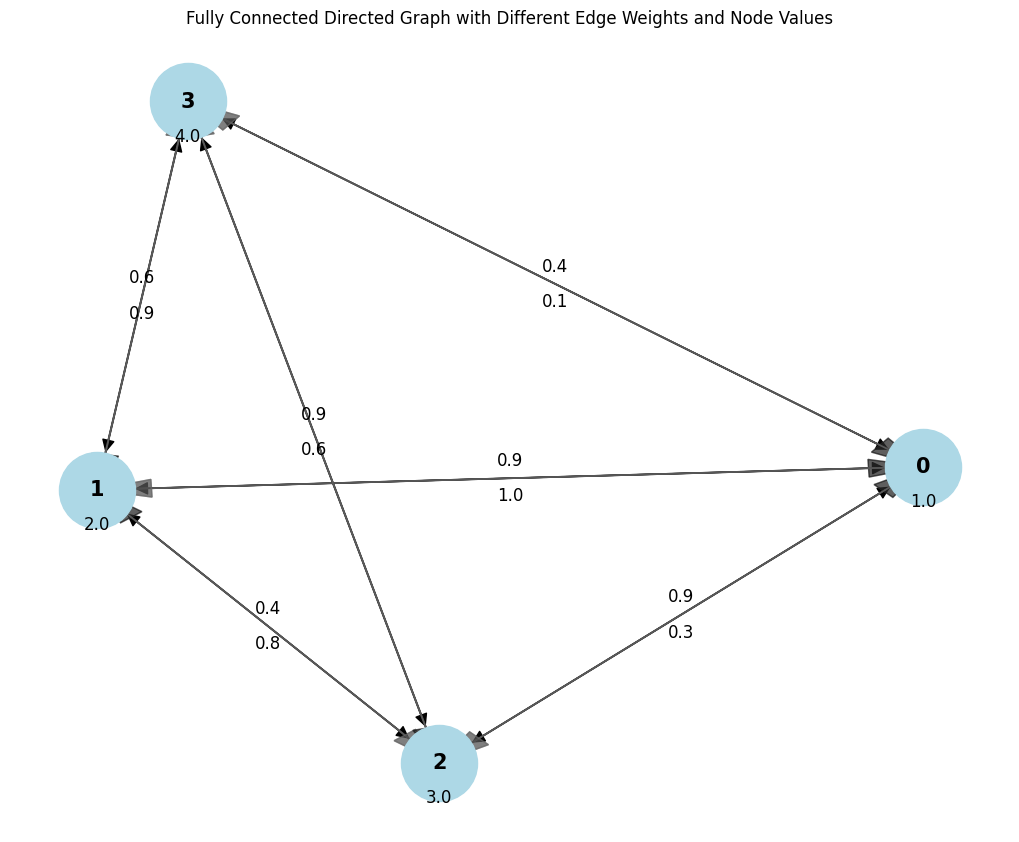

In [4]:


# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add nodes with initial features
node_labels = {0: 1.0, 1: 2.0, 2: 3.0, 3: 4.0}
for node, feature in node_labels.items():
    G.add_node(node, value=feature)

# Add edges with random weights
edges = [(edge_index[0, i].item(), edge_index[1, i].item(), edge_attr[i].item()) for i in range(edge_index.size(1))]

for src, tgt, weight in edges:
    G.add_edge(src, tgt, weight=weight)

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=15, font_weight='bold', arrowsize=20)

# Draw node values below the nodes
node_values = nx.get_node_attributes(G, 'value')
for node, value in node_values.items():
    x_, y = pos[node]
    plt.text(x_, y - 0.1, f'{value:.1f}', fontsize=12, ha='center', va='center')

# Draw edges with different labels and positions
for (src, tgt, weight) in edges:
    # Get the position of source and target nodes
    x1, y1 = pos[src]
    x2, y2 = pos[tgt]
    
    # Draw an arrow from source to target
    plt.arrow(x1, y1, x2 - x1, y2 - y1, length_includes_head=True, head_width=0.05, head_length=0.1, color='black', alpha=0.5)
    
    # Draw a second arrow from target to source for bidirectional edges
    plt.arrow(x2, y2, x1 - x2, y1 - y2, length_includes_head=True, head_width=0.05, head_length=0.1, color='gray', alpha=0.5)
    
    # Calculate position for the weight label
    label_pos_x = (x1 + x2) / 2
    label_pos_y = (y1 + y2) / 2
    
    # Adjust label position slightly for clarity
    if src < tgt:
        label_pos_y += 0.05
    else:
        label_pos_y -= 0.05
    
    # Draw the weight label
    plt.text(label_pos_x, label_pos_y, f'{weight:.1f}', fontsize=12, ha='center', va='center')

plt.title('Fully Connected Directed Graph with Different Edge Weights and Node Values')
plt.show()


In [5]:

# Find incoming edges to node 0
incoming_edges_to_node_0 = (edge_index[1] == 0).nonzero(as_tuple=True)[0]
print("Incoming edges to node 0:", incoming_edges_to_node_0)

# Extract corresponding edge weights and node features
weights_to_node_0 = edge_attr[incoming_edges_to_node_0]
nodes_from = edge_index[0, incoming_edges_to_node_0]
features_from_nodes = x[nodes_from]

print(weights_to_node_0)
# Calculate expected value for node 0
expected_value_node_0 = torch.round((weights_to_node_0.view(-1, 1) * features_from_nodes).sum(), decimals=2)
print("Expected value of node 0:", expected_value_node_0.item())


# Create a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# Define the Message Passing model
class SimpleMPNN(MessagePassing):
    def __init__(self):
        super(SimpleMPNN, self).__init__(aggr='add')  # "Add" aggregation (sum)

    def forward(self, x, edge_index, edge_attr):
        return self.propagate(edge_index, x=x, edge_weight=edge_attr)
    
    def message(self, x_j, edge_weight):
        # x_j: features of neighboring nodes
        # edge_weight: weights of the edges
        msg = edge_weight.view(-1, 1) * x_j
        # print(f"Message from node {x_j}: {msg}")
        return msg

    def update(self, aggr_out):
        return aggr_out

# Instantiate the model
model = SimpleMPNN()

# Perform a forward pass
output = model(x, edge_index, edge_attr)
print("Output node features after message passing:\n", output)
print("Node value of node 0 after message passing:\n", output)

torch._assert( abs(output[0]-expected_value_node_0) <= 0.1, message="Node 0 has received a different message")

Incoming edges to node 0: tensor([3, 6, 9])
tensor([0.9593, 0.2566, 0.1332])
Expected value of node 0: 3.2200000286102295
Output node features after message passing:
 tensor([[3.2211],
        [7.0016],
        [4.0702],
        [4.4070]])
Node value of node 0 after message passing:
 tensor([[3.2211],
        [7.0016],
        [4.0702],
        [4.4070]])


# Dataloader for graphs

Create graph with nodes, where a single node contains a value,error,preds

In [6]:
from torch_geometric.utils import from_networkx, to_dense_adj


class GraphBuilder:

    def __init__(self, internal_nodes, supervised_learning, graph_type):

        
        allowed_topologies = ["fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"]
        assert graph_type["name"].lower() in allowed_topologies, "Graph structure unkown"
        self.graph_type = graph_type

        # check if graph tpye aligns with the needed graph_params 
        # TODO 

        self.SENSORY_NODES = 784
        
        self.num_sensor_nodes = range(self.SENSORY_NODES)
        self.NUM_INTERNAL_NODES = internal_nodes
        self.num_internal_nodes = range(self.SENSORY_NODES, self.SENSORY_NODES + self.NUM_INTERNAL_NODES)
        self.INTERNAL = self.num_internal_nodes

        self.supervised_learning = supervised_learning
        # self.supervised_learning = 
        
        if self.supervised_learning:
            self.num_all_nodes = range(self.SENSORY_NODES + self.NUM_INTERNAL_NODES + 10)  # Adding 10 label nodes
        else:
            self.num_all_nodes = range(self.SENSORY_NODES + self.NUM_INTERNAL_NODES)

        self.graph_params = graph_type["params"]
        self.create_graph()


    def get_data():

        return 

    def create_graph(self):

        self.edge_index = []

        if self.graph_type["name"] == "fully_connected":
            self.fully_connected(self_connection=False)
        elif self.graph_type["name"] == "fully_connected_w_self":
            self.fully_connected(self_connection=True)
        elif self.graph_type["name"] == "barabasi":
            self.barabasi()
        elif self.graph_type["name"] == "stochastic_block":
            self.stochastic_block()

        elif self.graph_type["name"] == "fully_connected_no_sens2sup":
            self.fully_connected_no_sens2sup()
        

        # Convert edge_index to tensor only if it's not already a tensor
        if not isinstance(self.edge_index, torch.Tensor):
            self.edge_index = torch.tensor(self.edge_index, dtype=torch.long)

        # Transpose if edge_index was manually created
        if self.graph_type["name"] in ["fully_connected", "fully_connected_w_self", "fully_connected_no_sens2sup", "barabasi"]:
            self.edge_index = self.edge_index.t().contiguous()
            self.edge_index_tensor = self.edge_index.t().contiguous()

    def fully_connected_no_sens2sup(self):

        print("Creating fully connected graph without sensory to internal (and otherwayaround)")
        # Sensory to sensory (both ways)
        for i in self.num_sensor_nodes:
            for j in self.num_sensor_nodes:
                if i != j:
                    self.edge_index.append([i, j])

        # Sensory to internal (both ways )
        for i in self.num_sensor_nodes:
            for j in self.num_internal_nodes:
                self.edge_index.append([i, j])
                self.edge_index.append([j, i])

        # Internal to internal (both directions)
        for i in self.num_internal_nodes:
            for j in self.num_internal_nodes:
                if i != j:
                    self.edge_index.append([i, j])

        if self.supervised_learning:
            # Internal to label (both directions)
            label_nodes = range(self.SENSORY_NODES + self.NUM_INTERNAL_NODES, self.SENSORY_NODES + self.NUM_INTERNAL_NODES + 10)
            for i in self.num_internal_nodes:
                for j in label_nodes:
                    self.edge_index.append([i, j])
                    self.edge_index.append([j, i])
            


    def fully_connected(self, self_connection):
        if self_connection:
            print("Creating fully connected directed graph with self connections")
            self.edge_index += [[i, j] for i in self.num_all_nodes for j in self.num_all_nodes]
        else:
            print("Creating fully connected directed graph without self connections")
            self.edge_index += [[i, j] for i in self.num_all_nodes for j in self.num_all_nodes if i != j]
        
    def barabasi(self):
        num_nodes = len(self.num_all_nodes)
        m = self.graph_params.get("m", 5)  # Number of edges to attach from a new node to existing nodes
        G = nx.barabasi_albert_graph(num_nodes, m)
        self.edge_index = [[u, v] for u, v in G.edges()]
        print(f"Creating Barabási-Albert graph with {num_nodes} nodes and {m} edges to attach per new node")

    
    def stochastic_block(self):

        # Given code parameters; else take default 40, 50
        num_communities = self.graph_params.get("num_communities", 40)  # Example block sizes
        community_size = self.graph_params.get("community_size",   50)

        print(num_communities, community_size,  len(self.num_internal_nodes) )
        assert (num_communities * community_size) == len(self.num_internal_nodes), "must be equal"
        # Sizes of communitieser
        sizes = [community_size for _ in  range(num_communities)]
        SENSORY_NODES = range(0, self.SENSORY_NODES)
        self.INTERNAL = range(self.SENSORY_NODES, (self.SENSORY_NODES+sum(sizes)))
        self.num_internal_nodes = sum(self.INTERNAL)
        SUPERVISED_NODES = range(self.SENSORY_NODES+sum(sizes), sum(sizes)+10)

        sizes.insert(0, self.SENSORY_NODES)
        sizes.append(10)
        community_sizes = sizes

        num_communities = len(community_sizes)
        p_intra = 0.5  # Probability of edges within the same community
        p_inter = 0.1  # Probability of edges between different communities

        # Create the stochastic block model graph
        p = np.full((num_communities, num_communities), p_inter)
        np.fill_diagonal(p, p_intra)
        p[0, 0] = 0
        for i in range(1, num_communities):
            p[0, i] = 0.1
            p[i, 0] = 0.1

        if self.graph_params.get("remove_sens_2_sup", True):
            # remove sensory to supervised
            p[0, -1] = 0 
            p[-1, 0] = 0 

        G = nx.stochastic_block_model(sizes, p, directed=True)
     
        # Convert the graph to an adjacency matrix
        # adj_matrix = nx.adjacency_matrix(G).todense()

        # Convert the NetworkX graph to PyTorch Geometric format
        data = from_networkx(G)

        # Extract the edge_index tensor
        self.edge_index = data.edge_index

        print("Creating Stochastic Block Model graph")


In [7]:
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

class CustomGraphDataset(Dataset):
    def __init__(self, graph_params, mnist_dataset, supervised_learning, numbers_list,  
                 same_digit=False,
                 add_noise=False, noise_intensity=0.1, 
                 include_self_connections=False, N=2,
                 edge_index=None):
        self.mnist_dataset = mnist_dataset
        # self.graph_structure = graph_structure
        self.NUM_INTERNAL_NODES = graph_params["internal_nodes"]
        self.add_noise = add_noise
        self.noise_intensity = noise_intensity
        self.same_digit = same_digit
        self.supervised_learning = supervised_learning
        self.include_self_connections = include_self_connections
        self.N = N.lower() if type(N)==str else N

        if self.supervised_learning:
            print("Supervised learning")
        else:
            print("Un supervised learning")
        
        print(f"Taking first n={self.N} digits from each class")

        if numbers_list:
            self.numbers_list = numbers_list
        else:
            self.numbers_list = list(range(10))

        # Instead of storing just the first occurrence, store all occurrences of each digit
        self.indices = {int(digit): [] for digit in self.numbers_list}

        # Populate the indices dictionary with all occurrences of each digit
        for idx, (image, label) in enumerate(self.mnist_dataset):
            if int(label) in self.numbers_list:
                self.indices[int(label)].append(idx)

        # ------------------- Create the graph structure -------------------
        # FOR TESTING THE METHOD of MESSAGE PASSING
        # SENSORY_NODES = 10 # 784
        SENSORY_NODES = 784 # 784
        NUM_INTERNAL_NODES = self.NUM_INTERNAL_NODES 
        num_sensor_nodes    = range(SENSORY_NODES)
        num_internal_nodes  = range(SENSORY_NODES, SENSORY_NODES + NUM_INTERNAL_NODES)

        if self.supervised_learning:
            num_all_nodes = range(SENSORY_NODES + NUM_INTERNAL_NODES + 10)
        else:
            num_all_nodes = range(SENSORY_NODES + NUM_INTERNAL_NODES)

        if edge_index is not None:
            self.edge_index = edge_index
            self.edge_index_tensor = self.edge_index
        else:


            loader = GraphBuilder(**graph_params)
            
            self.edge_index = loader.edge_index
            self.edge_index_tensor = self.edge_index

            # self.NUM_INTERNAL_NODES_range = loader.INTERNAL
            # self.NUM_INTERNAL_NODES = sum(loader.num_internal_nodes)
            
          
            # Convert the edge list to a PyTorch tensor and transpose it to match the expected shape (2, num_edges)
            # self.edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        # # Initialize the weights for the edges
        # self.weights = torch.ones(self.edge_index_tensor.size(1))
        
        # # Convert to sparse representation
        # self.sparse_weights = torch.sparse.FloatTensor(self.edge_index_tensor, self.weights, torch.Size([len(num_all_nodes), len(num_all_nodes)]))

    def get_edge_weight(self, i, j):
        """
        Retrieve the weight of the edge from node i to node j.

        Parameters:
        i (int): Source node index.
        j (int): Target node index.

        Returns:
        float: Weight of the edge from node i to node j.
        """
        edge_indices = (self.edge_index_tensor[0] == i) & (self.edge_index_tensor[1] == j)
        if edge_indices.any():
            return self.weights[edge_indices.nonzero(as_tuple=True)[0]].item()
        else:
            return 0.0, False  # Return 0 if no such edge exists
        
    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        
        if self.same_digit:
            # fix idx to be the same digit
            selected_idx = 9
        else:
            digit = np.random.choice(self.numbers_list)
        
            # Randomly select an index from the list of indices for the selected digit
            digit_indices = self.indices[digit]

            if self.N == "all":
                self.N = len(digit_indices)
            digit_indices = digit_indices[0:self.N]
            selected_idx = np.random.choice(digit_indices)

        print("Selected idx: ", selected_idx)

        # Get the image and label from the dataset using the randomly selected index
        image, label = self.mnist_dataset[selected_idx]
        clean_image = image.clone()  # Store the clean image

        # Optionally add noise to the image
        if self.add_noise:
            noise = torch.randn(image.size()) * self.noise_intensity
            image = image + noise
            # Ensure the noisy image is still within valid range
            image = torch.clamp(image, 0, 1)
        

        # Initialize sensory nodes with image values
        if self.supervised_learning:
            # the sensory nodes are fixed to a 1-hot vector with the labels
            # we want outgoing edges from the label_nodes (1 hot of 10 classes) to the pixel nodes

            # Create a one-hot encoded vector of the label
            label_vector = torch.zeros(10)  # Assuming 10 classes for MNIST
            label_vector[label] = 10

            # Concatenate the label vector with the image vector
            # concat the image, internal nodes (zeros) and label nodes
            print("adding label", label, label_vector)

            values = torch.cat((image.view(-1, 1), torch.zeros(self.NUM_INTERNAL_NODES).view(-1, 1), label_vector.view(-1, 1)), dim=0)    
            # values = torch.cat((one_hot.view(-1, 1), torch.zeros(self.NUM_INTERNAL_NODES).view(-1, 1), label_vector.view(-1, 1)), dim=0)

            # x = torch.cat((image.view(-1, 1), label_vector.view(-1, 1)), dim=0)
        else:
            # Flatten image to use as part of the node features
            # NO: concat the image, internal nodes (zeros) and label nodes
            # YES: concat the image
            values = torch.cat((image.view(-1, 1), torch.zeros(self.NUM_INTERNAL_NODES).view(-1, 1)), dim=0)
            # values = torch.cat((one_hot.view(-1, 1), torch.zeros(self.NUM_INTERNAL_NODES).view(-1, 1)), dim=0)
            # x = image.view(-1, 1)

        # Node features: value, prediction, and error for each node
        errors = torch.zeros_like(values)
        predictions = torch.zeros_like(values)

        # Combine attributes into a feature matrix
        features = torch.stack((values, errors, predictions), dim=1)

        # assign the weights to the edges to be 1 
        edge_attr = torch.ones(self.edge_index_tensor.size(1))

        self.edge_attr = edge_attr

        return Data(x=features, edge_index=self.edge_index_tensor, y=label, edge_attr=edge_attr), clean_image.squeeze(0)
        # return Data(x=features, edge_index=self.edge_index_tensor, y=label), clean_image.squeeze(0)



# label_vector[label] = 100


In [46]:
# CustomGraphDataset params
dataset_params = {
    # "mnist_dataset":            mini,
    "mnist_dataset":            mnist_trainset,
    "supervised_learning":      True,
    "numbers_list":             [0, 1, 3, 4, 5, 6],
    # "NUM_INTERNAL_NODES":       ,
    "same_digit":               False,
    "add_noise":                False,
    "noise_intensity":          0.0,
    "include_self_connections": True,
    "N":                        20,     # taking the first n instances of each digit or use "all"
    "edge_index":               None,
} 


# Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
graph_params = {
    "internal_nodes": 1500,  # Number of internal nodes
    "supervised_learning": True,  # Whether the task involves supervised learning
    "graph_type": 

      {    
        "name": "stochastic_block", # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block", "fully_connected_no_sens2sup"
        "params":   
          {
            "num_communities": 50,      # Number of communities
            "community_size": 30,       # Size of each community
            "p_intra": 0.5,             # Probability of edges within the same community
            "p_inter": 0.1,             # Probability of edges between different communities
            "remove_sens_2_sup":True,
          }
      },


      # {    
      #   "name": "fully_connected_w_self", # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
      #   "params": None
      # },

      # {    
      #   "name": "fully_connected_no_sens2sup", # Options: "fully_connected", "fully_connected_w_self", "barabasi", "stochastic_block"
      #   "params": None
      # },
      
  
}

if graph_params["graph_type"]["name"] == "stochastic_block":
  assert graph_params["internal_nodes"] == (graph_params["graph_type"]["params"]["num_communities"] * graph_params["graph_type"]["params"]["community_size"])

# Define the graph type

# Initialize the GraphBuilder
custom_dataset_train = CustomGraphDataset(graph_params, **dataset_params)

dataset_params["batch_size"] = 4
dataset_params["NUM_INTERNAL_NODES"] = graph_params["internal_nodes"]
# dataset_params["NUM_INTERNAL_NODES"] = (custom_dataset_train.NUM_INTERNAL_NODES)

print("Device \t\t\t:", device)
print("SUPERVISED on/off \t", dataset_params["supervised_learning"])


Supervised learning
Taking first n=20 digits from each class
50 30 1500
Creating Stochastic Block Model graph
Device 			: cuda
SUPERVISED on/off 	 True


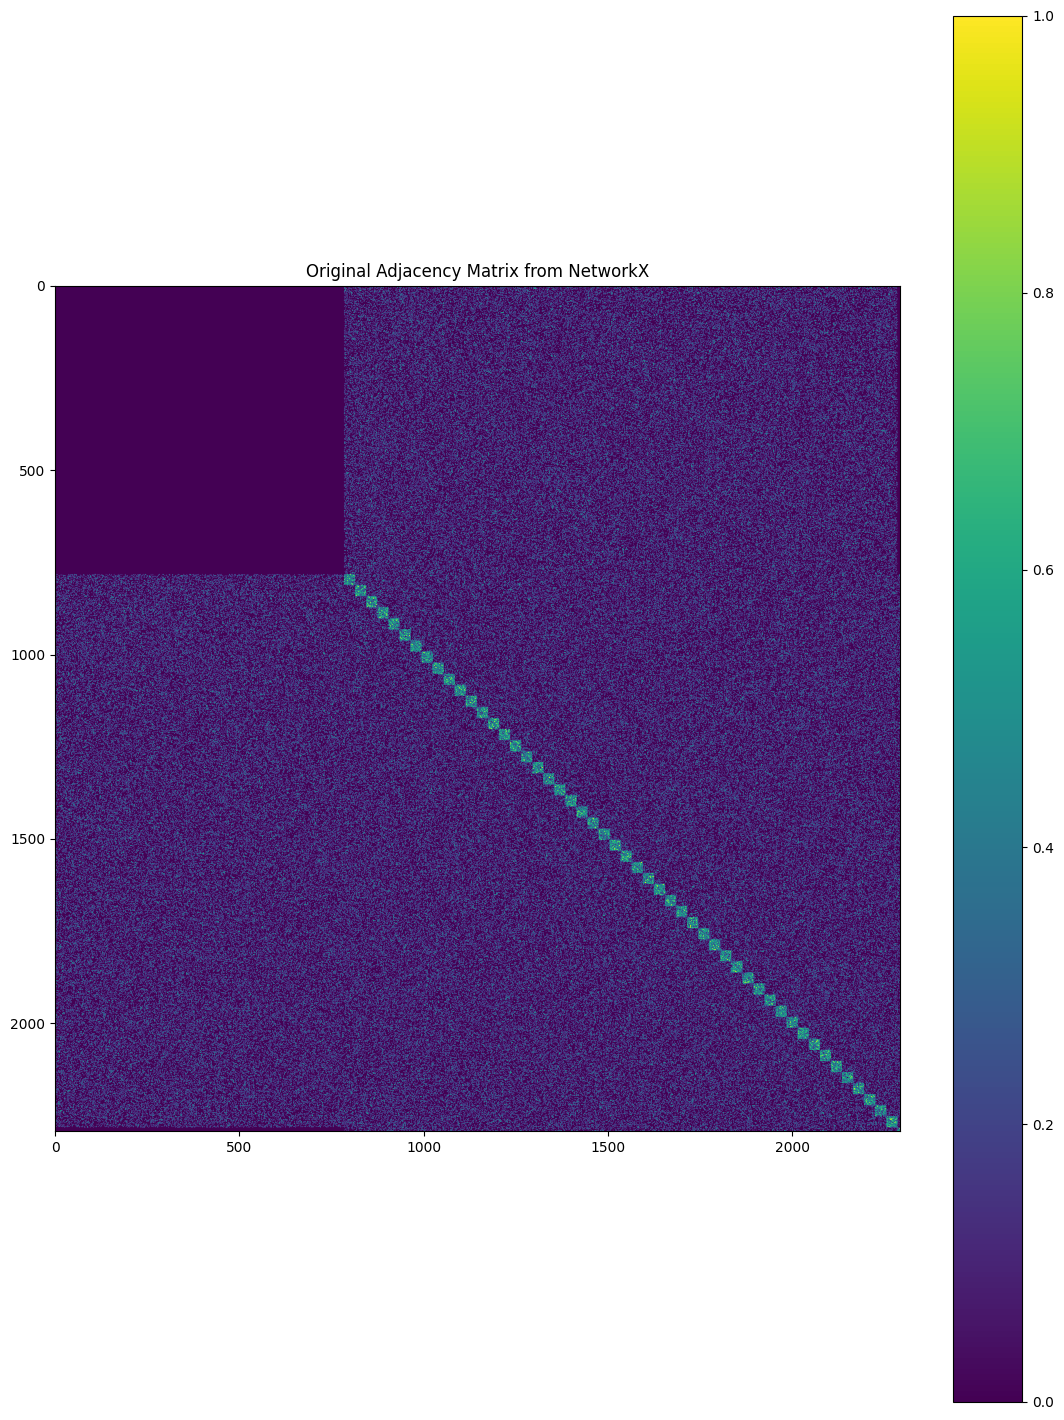

In [47]:
# Convert edge_index to adjacency matrix
adj_matrix_pyg = to_dense_adj(custom_dataset_train.edge_index)[0].numpy()
# adj_matrix_pyg = to_dense_adj(custom_dataset_train.edge_index_tensor)[0].numpy()

# Plot the adjacency matrices for visual comparison
plt.figure(figsize=(30, 18))

plt.subplot(1, 2, 1)
plt.imshow(adj_matrix_pyg, cmap='viridis')
plt.title("Original Adjacency Matrix from NetworkX")
plt.colorbar()

In [48]:

train_loader = DataLoader(custom_dataset_train, 
                          batch_size=dataset_params["batch_size"], 
                          shuffle=True, 
                        #   num_workers=4
                          )

img_size = 28*28
# num_vertices = img_size + NUM_INTERNAL_NODES  # Number of nodes in the graph
# sensory_indices = [i for i in range(0,img_size)]  # Assuming node 0 is a sensory node
# internal_indices = [i for i in range(img_size, num_vertices)]  # The rest are internal nodes

# NUM_INTERNAL_NODES = self.NUM_INTERNAL_NODES 
# num_sensor_nodes    = range(784)
# num_internal_nodes  = range(784, 784 + NUM_INTERNAL_NODES)
# num_label_nodes     = range(784 + NUM_INTERNAL_NODES, 784 + NUM_INTERNAL_NODES + 10)

# sensory_indices    = range(784)

# NUM_SENSORY = 10 
NUM_SENSORY = 784
sensory_indices    = range(NUM_SENSORY)


internal_indices   = range(NUM_SENSORY, NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"])
num_vertices = NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"]  # Number of nodes in the graph
supervised_labels = None

if dataset_params["supervised_learning"]:
    label_indices     = range(NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"], NUM_SENSORY + dataset_params["NUM_INTERNAL_NODES"] + 10)
    supervised_labels = label_indices
    num_vertices += 10

print("sensory_indices\t\t:", len(sensory_indices), sensory_indices[0], "...", sensory_indices[-1])
print("internal_indices\t:", len(internal_indices), internal_indices[0], "...", internal_indices[-1])
print("num_vertices \t\t:", num_vertices)

if dataset_params["supervised_learning"]:
  assert num_vertices == len(sensory_indices) + len(internal_indices) + 10, "Number of vertices must match the sum of sensory and internal indices + labels"
else:
  assert num_vertices == len(sensory_indices) + len(internal_indices), "Number of vertices must match the sum of sensory and internal indices"


sensory_indices		: 784 0 ... 783
internal_indices	: 1500 784 ... 2283
num_vertices 		: 2294


In [49]:
print(train_loader.batch_size)
for batch, clean_image in train_loader:
    
    values, errors, predictions = batch.x[:, 0], batch.x[:, 1], batch.x[:, 2]
  
    x, edge_index, y, edge_weight = batch.x, batch.edge_index, batch.y, batch.edge_attr
    print("edge_index", edge_index.shape)

    print(batch.x[:, 0].shape)
    print(custom_dataset_train.edge_index.shape)
    break

4
Selected idx:  107
adding label 3 tensor([ 0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.])
Selected idx:  47
adding label 5 tensor([ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.])
Selected idx:  83
adding label 6 tensor([ 0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.])
Selected idx:  166
adding label 4 tensor([ 0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.])
edge_index torch.Size([2, 1922092])
torch.Size([9176, 1])
torch.Size([2, 480523])


The dataloader contains the two graphs into a single network with to disconnected graphs. It also concats the edge_index vectors together so, actually with doing batch learning we are storing and computing the edge weights. 

torch.Size([9176, 9176])


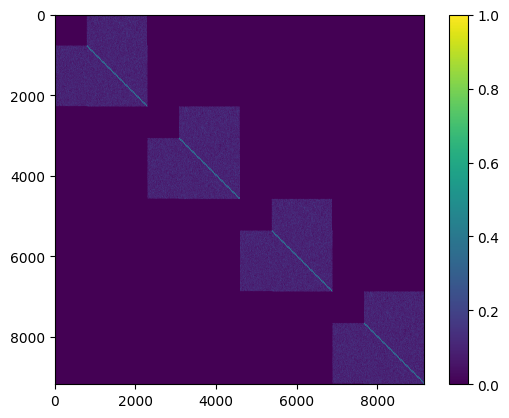

In [50]:
from torch_geometric.utils import to_dense_adj, dense_to_sparse

# Convert edge_index to a dense adjacency matrix
adj_matrix = to_dense_adj(edge_index).squeeze(0)
print(adj_matrix.shape)

plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

<!-- <p> with and without self-connection    | (sensory to sensory)  -->

# MessagePassing 

In [14]:
from typing import Any
from torch_geometric.nn import GCNConv
# ------------------------------------------

import torch
from typing import Any

class Swish:
    def forward(self, x):
        return x * torch.sigmoid(x)

    def f_prime(self, x):
        # Derivative of Swish: sigmoid(x) + x * sigmoid(x) * (1 - sigmoid(x))
        sigmoid_x = torch.sigmoid(x)
        return sigmoid_x + x * sigmoid_x * (1 - sigmoid_x)



def set_activation(activation):
    
    swish = Swish()

    activation_functions = {
        "tanh": torch.tanh,
        "relu": torch.relu,
        "leaky relu": torch.nn.functional.leaky_relu,  # Note: requires passing an additional argument for the negative slope, handled below
        "linear": lambda x: x,
        "sigmoid": torch.sigmoid,
        "hard_tanh": torch.nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False, min_value=None, max_value=None),
        "swish": swish.forward,
    }

    derivative_functions = {
        "tanh": lambda x: 1 - torch.tanh(x)**2,
        "relu": lambda x: torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x)),
        "leaky relu": lambda x: torch.where(x > 0, torch.ones_like(x), 0.1 * torch.ones_like(x)),
        "linear": lambda x: torch.ones_like(x),
        "sigmoid": lambda x: torch.sigmoid(x) * (1 - torch.sigmoid(x)),
        "hard_tanh": lambda x: torch.where((x >= -1.0) & (x <= 1.0), torch.ones_like(x), torch.zeros_like(x)), 
        "swish": swish.f_prime
    }
    if activation not in activation_functions:
        raise NotImplementedError(f"Invalid activation function: {activation}. Supported activations are: {', '.join(activation_functions.keys())}")

    # Special-handling for "leaky relu" to pass the negative_slope parameter
    if activation == "leaky relu":
        f = lambda x: activation_functions[activation](x, negative_slope=0.1)
    else:
        f = activation_functions[activation]

    f_prime = derivative_functions[activation]

    return f, f_prime


In [15]:
import torch
from torch_geometric.nn import MessagePassing



class PredictionMessagePassing(MessagePassing):
    def __init__(self, aggr='add', activation=None):
        super(PredictionMessagePassing, self).__init__(aggr=aggr,flow="source_to_target")
        # Initialize the activation function and its derivative
        self.f, self.activation_derivative = set_activation(activation)

        # GET THIS with init. the 
        # self.edge_index = edge_index

    def forward(self, x, edge_index, weight_matrix):
        # x: Node features (values, errors, predictions)
        # edge_index: Graph connectivity (2, num_edges)
        # edge_weight: Edge weights (num_edges,)

        # Perform message passing
        # μi,t = ∑_j θj,i * f(xj,t)

        # need to have  num_nodes,3 (features) not N,3,1 
        if x.dim() == 3 and x.size(2) == 1:
            x = x.squeeze(2)  # Now x should have shape (num_nodes, 3)

         # Step 3: Compute normalization.
        # row, col = edge_index
        # deg = degree(col, x.size(0), dtype=x.dtype)
        # deg_inv_sqrt = deg.pow(-0.5)
        # deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        # norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # row, col = edge_index
        # thetaIJ = weight_matrix[row, col]  # Use the weight from the 2D matrix
        # thetaJI = weight_matrix[col, row]  # Use the weight from the 2D matrix

        # print("theta_ji pred", thetaJI)


        return self.propagate(edge_index, x=x, weight_matrix=weight_matrix, norm=None)

        # return self.propagate(edge_index, x=x, edge_weight=edge_weight, norm=norm)

    def message(self, x_j, weight_matrix, norm):
        # x_j: Node features of the neighboring nodes
        # edge_weight: Weights of the edges

        # Compute the message for each edge, which is the weighted activated value of the neighboring node

        # COMPUTES θj,i * f(xj,t) for each edge
        
        # return thetaJI * self.activation(x_j[:, 0]).view(-1, 1)

               
        return weight_matrix.view(-1, 1) * self.f(x_j[:, 0]).view(-1, 1)
        # return norm.view(-1, 1) * edge_weight.view(-1, 1) * self.activation(x_j[:, 0]).view(-1, 1)

    def update(self, aggr_out, x):
        # aggr_out: Aggregated messages for each node
        # x: Node features (values, errors, predictions)

        # Extract current values, errors, and predictions
        # values, errors, predictions = x[:, 0], x[:, 1], x[:, 2]

        # Update predictions based on aggregated messages
        # μi,t is updated with the aggregated message
        predictions = aggr_out

        return predictions.view(-1,1)
       


import torch
from torch_geometric.nn import MessagePassing

class ValueMessagePassing(MessagePassing):
    def __init__(self, aggr='add', activation=None):
        super(ValueMessagePassing, self).__init__(aggr=aggr, flow="source_to_target")
        # Initialize the activation function and its derivative
        self.activation, self.f_prime = set_activation(activation)

    def forward(self, x, edge_index, weight_matrix):
        # x: Node features (values, errors, predictions)
        # edge_index: Graph connectivity (2, num_edges)
        # edge_weight: Edge weights (num_edges,)

        # need to have  num_nodes,3 (features) not N,3,1 
        if x.dim() == 3 and x.size(2) == 1:
            x = x.squeeze(2)  # Now x should have shape (num_nodes, 3)

        # Perform message passing

        # row, col = edge_index
        # theta_ij = weight_matrix[row, col]      # Use the weight from the 2D matrix
        # thetaJI = weight_matrix[col, row]       # Use the weight from the 2D matrix

        # print("theta_ji", thetaJI)
        return self.propagate(edge_index, x=x, weight_matrix=weight_matrix)

    def message(self, x_j, weight_matrix):
        # x_j: Node features of the neighboring nodes (source nodes in edge_index)
        # x_i: Node features of the destination nodes in edge_index
        # edge_weight: Weights of the edges

        # Compute the message for each edge, which is the error times the edge weight
        # ε_{k,t} θ_{k,i}
        # errors_j = x_j[:, 1].view(-1, 1)  # Errors of the source nodes
        # return edge_weight.view(-1, 1) * errors_j

        errors_j = x_j[:, 1].view(-1, 1)
        return weight_matrix.view(-1, 1) * errors_j


    def update(self, aggr_out, x):
        # aggr_out: Aggregated messages for each node
        # x: Node features (values, errors, predictions)

        # Extract current values and errors
        values, errors = x[:, 0], x[:, 1]

        # Compute the derivative of the activation function applied to the values
        f_prime_x_i = self.f_prime(values).view(-1, 1)

        # Compute the change in values using the provided equation
        # Δx_{i,t} = γ (-ε_{i,t} + f'(x_{i,t}) ∑_k ε_{k,t} θ_{k,i})
        delta_x = (-errors.view(-1, 1) + f_prime_x_i * aggr_out)

        return delta_x.view(-1,1)

### Verification of Prediction Message Passing

**Objective:**  
To verify that the `PredictionMessagePassing` class correctly implements the message-passing mechanism for updating node predictions according to the rules defined in the paper.

**What We Are Verifying:**
1. **Message Calculation:**
   - For each node $i$, the predicted value $\mu_{i,t}$ should be calculated as:
     $$
     \mu_{i,t} = \sum_{j} \theta_{j,i} f(x_{j,t})
     $$
   - Here, $\theta_{j,i}$ is the weight of the edge from node $j$ to node $i$, and $f(x_{j,t})$ is the activation function applied to the value at node $j$.

2. **Expected Outcome:**
   - The output of the `PredictionMessagePassing` should match the manually calculated expected predictions for each node based on the incoming messages from connected nodes.

### Verification of Value Message Passing

**Objective:**  
To verify that the `ValueMessagePassing` class correctly implements the message-passing mechanism for updating node values according to the rules defined in the paper.

**What We Are Verifying:**
1. **Value Update Calculation:**
   - For each node $i$, the change in its value $\Delta x_{i,t}$ should be calculated as:
     $$
     \Delta x_{i,t} = \gamma \left(-\epsilon_{i,t} + f'(x_{i,t}) \sum_{k} \epsilon_{k,t} \theta_{k,i}\right)
     $$
   - Here, $\gamma$ is a learning rate, $\epsilon_{i,t}$ is the prediction error, and $f'(x_{i,t})$ is the derivative of the activation function applied to the value at node $i$.

2. **Expected Outcome:**
   - The output of the `ValueMessagePassing` should match the manually calculated expected updates for each node's value based on the incoming errors from connected nodes.


For testing we take 3 node with each fixed value, but every time a different act. function and edge weights

In [16]:
activation_functions = [
    "tanh",
    "relu",
    "leaky relu",
    "linear",
    "sigmoid",
    "hard_tanh",
    "swish"]

In [17]:
import torch

def verify_prediction_message_passing(activation_functions):

    act = random.choice(list(activation_functions))
    print("Using activation function: ", act)

    # Node features: (values, errors, predictions)
    node_values = torch.tensor([[1.0], [0.5], [0.3]])
    node_errors = torch.tensor([[0.1], [0.2], [0.4]])
    node_preds = torch.tensor([[0.2], [0.3], [0.5]])
    
    # Combine them into a single tensor
    x = torch.cat((node_values, node_errors, node_preds), dim=1)
  
    edge_index = torch.tensor([[0, 1, 2], [1, 2, 0]])  # Edge connections
    
    # Define edge weights corresponding to the edges in edge_index
    # edge_weights = torch.tensor([1.0, 0.8, 0.5])  # Edge weights for edges 0->1, 1->2, 2->0
    # random edge weights 
    edge_weights = torch.randn(3)

    # Instantiate the PredictionMessagePassing with ReLU activation
    mp = PredictionMessagePassing(activation=act)
    output = mp(x, edge_index, edge_weights)

    # Manually calculate expected outputs based on the update rule from the paper
    f, f_prime = set_activation(act)

    expected_output = torch.zeros(x.size(0), 1)
    
    for i in range(x.size(0)):
        incoming_edges = (edge_index[1] == i).nonzero(as_tuple=True)[0]
        messages = []
        for edge in incoming_edges:
            src_node = edge_index[0, edge].item()
            weight = edge_weights[edge].item()
            messages.append(weight * f(x[src_node, 0]).item())
        expected_output[i, 0] = sum(messages)

    # Check if output matches the expected values based on the paper's formula
    print("Prediction Message Passing Output:\n", output)
    print("Expected Output:\n", expected_output)

    assert torch.allclose(output, expected_output, atol=1e-5), "PredictionMessagePassing output does not match the expected output."

# Run verification tests
verify_prediction_message_passing(activation_functions)

Using activation function:  hard_tanh
Prediction Message Passing Output:
 tensor([[0.1605],
        [0.4617],
        [0.1337]])
Expected Output:
 tensor([[0.1605],
        [0.4617],
        [0.1337]])


In [18]:
import torch

def verify_value_message_passing(activation_functions):

    act = random.choice(list(activation_functions))
    print("Using activation function", act)
    # Define node features: (values, errors, predictions)
    node_values = torch.tensor([[1.0], [0.5], [0.3]])
    node_errors = torch.tensor([[0.1], [0.2], [0.4]])
    node_preds = torch.tensor([[0.2], [0.3], [0.5]])
    
    # Combine them into a single tensor
    x = torch.cat((node_values, node_errors, node_preds), dim=1)
    
    # Define the edge index and edge weights
    edge_index = torch.tensor([[0, 1, 2], [1, 2, 0]])  # Edge connections
    edge_weights = torch.tensor([1.0, 0.8, 0.5])  # Edge weights for edges 0->1, 1->2, 2->0

    # Instantiate the ValueMessagePassing with ReLU activation
    mp = ValueMessagePassing(activation=act)
    output = mp(x, edge_index, edge_weights)

    # Manually calculate expected updates based on the update rule from the paper
    f, f_prime = set_activation(act)

    expected_output = torch.zeros(node_values.size(0), 1)
    
    for i in range(node_values.size(0)):
        incoming_edges = (edge_index[1] == i).nonzero(as_tuple=True)[0]
        aggr_message = 0.0
        for edge in incoming_edges:
            src_node = edge_index[0, edge].item()
            weight = edge_weights[edge].item()
            aggr_message += weight * node_errors[src_node, 0].item()
        
        # Calculate the update for the node value
        f_prime_x_i = f_prime(node_values[i, 0])
        expected_output[i, 0] = -node_errors[i, 0] + f_prime_x_i * aggr_message

    # Check if output matches the expected updates based on the paper's formula
    print("Value Message Passing Output:\n", output)
    print("Expected Output:\n", expected_output)

    assert torch.allclose(output, expected_output, atol=1e-5), "ValueMessagePassing output does not match the expected output."

# Run verification tests
verify_value_message_passing(activation_functions)

Using activation function tanh
Value Message Passing Output:
 tensor([[-0.0160],
        [-0.1214],
        [-0.2536]])
Expected Output:
 tensor([[-0.0160],
        [-0.1214],
        [-0.2536]])


___

PyG automatically takes care of batching multiple graphs into a single giant graph with the help of the torch_geometric.loader.DataLoader class. Internally, DataLoader is just a regular PyTorch torch.utils.data.DataLoader that overwrites its collate() functionality, i.e., the definition of how a list of examples should be grouped together. Therefore, all arguments that can be passed to a PyTorch DataLoader can also be passed to a PyG DataLoader, e.g., the number of workers num_workers.



Batch of N items: 

<b> Errors: </b>  |---graph1---|---graph2---|---...---|---graph_N---| 


<b> Values: </b>  |---graph1---|---graph2---|---...---|---graph_N---|  


<b> Predictions: </b>  |---graph1---|---graph2---|---...---|---graph_N---|





In its most general form, the PyG DataLoader will automatically increment the edge_index tensor by the cumulated number of nodes of all graphs that got collated before the currently processed graph, and will concatenate edge_index tensors (that are of shape [2, num_edges]) in the second dimension. The same is true for face tensors, i.e., face indices in meshes. All other tensors will just get concatenated in the first dimension without any further increasement of their values.

<b> Edge Index : </b>  |---graph1---|---graph2---|---...---|---graph_N---|


